In [110]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from typing import List

In [3]:
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere
rng = np.random.default_rng(2020)

In [112]:
def synaptic_input(i_mean: float, start: float, stop: float, step: float) -> (np.ndarray, np.ndarray):
    times = np.arange(start, stop, step)
    i_t_arr = i_mean * (1 + np.sin((2 * np.pi * times) / 0.01))
    return i_t_arr, times

def synaptic_input_random(i_mean: float, start: float, stop: float, step: float, rng) -> (np.ndarray, np.ndarray):
    times = np.arange(start, stop, step)
    random_values = rng.uniform(-1, 1, size = times.shape)
    i_t_arr = i_mean * (1 + (0.1 * np.sqrt(stop / step)) * random_values)
    return i_t_arr, times

def membrane_potential(
        initial_potential: float,
        start_t: float,
        stop_t: float,
        step_t: float,
        synaptic_inputs: np.ndarray,
) -> (np.ndarray, np.ndarray):
    potentials = []
    times = []
    t = start_t
    step_idx = 0
    current_potential = initial_potential
    while t < stop_t:
        # Get current state of the neuron
        current_synaptic_input = synaptic_inputs[step_idx] 
        
        # Calculate the next potential using a Euler step
        time_factor = step_t / tau
        next_potential = current_potential + time_factor * (el - current_potential + r * current_synaptic_input)
        
        # Increment state
        t += step_t
        step_idx += 1
        
        # Persist
        potentials.append(next_potential)
        times.append(t)
        current_potential = next_potential 

    return potentials, times

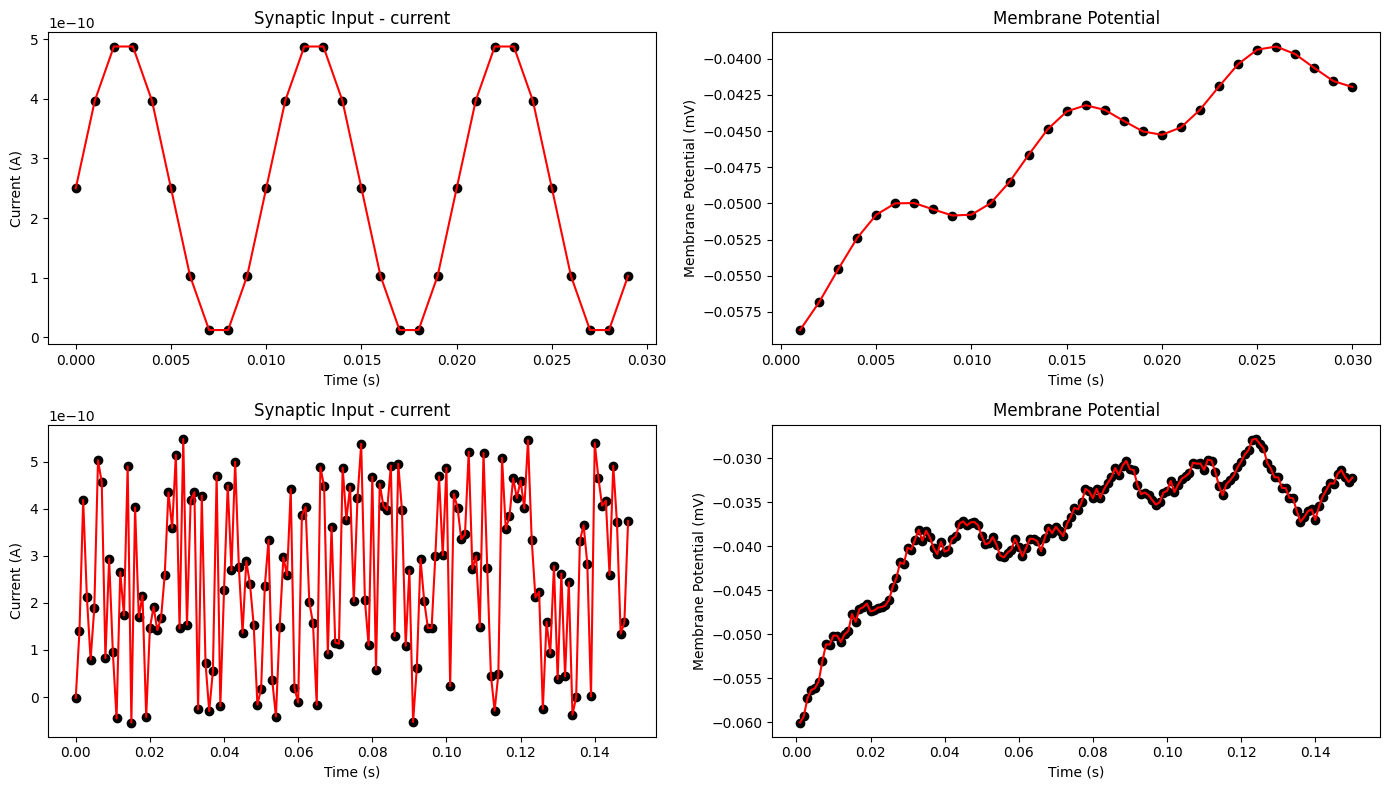

In [130]:
from matplotlib.axes import Axes

def plot_synaptic_inputs(ax: Axes, inputs, times: np.ndarray):
    ax.set_title('Synaptic Input - current')
    ax.plot(times, inputs, 'ko')
    ax.plot(times, inputs, 'red')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (A)')

def plot_n_experiments(
    ax: Axes,
    experiments: np.ndarray,
    means: np.ndarray,
    standard_deviation: np.ndarray,
):
    mean_potentials = means[0]
    mean_times = means[1]
    ax.set_title("N experiments")
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Membrane Potential (mV)")
    ax.plot(mean_times, mean_potentials, color='black', alpha=1.0)
    ax.plot(mean_times, mean_potentials + standard_deviation, color='blue')
    ax.plot(mean_times, mean_potentials - standard_deviation, color='blue')
    for experiment in experiments:
        potentials, times = experiment[0], experiment[1]
        ax.plot(times, potentials, alpha = 0.1)
    plt.show()

def plot_membrane_potential(ax: Axes, result: np.ndarray, times: np.ndarray):
    ax.set_title('Membrane Potential')
    ax.plot(times, result, 'ko')
    ax.plot(times, result, 'red')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Membrane Potential (mV)')

def plot_histograms(ax: Axes,samples: List[np.ndarray]):
    ax.set_title("Membrane Potential Histogram)")
    for i in range(len(samples)):
        potentials = samples[i]
        _, bin_edges = np.histogram(potentials, bins='auto')
        ax.hist(potentials, bins=bin_edges, color = random_color())

def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Plot non-random synaptic inputs
syn_inputs_reg, times_syn_reg = synaptic_input(i_mean, 0, 0.03, dt)
potentials_reg, times_potential_reg = membrane_potential(el, 0.0, 0.03, dt, syn_inputs_reg)
plot_synaptic_inputs(ax[0][0], syn_inputs_reg, times_syn_reg)
plot_membrane_potential(ax[0][1], potentials_reg, times_potential_reg)

# Plot random synpatic inputs and potentials
syn_inputs_rand, times_syn_rand = synaptic_input_random(i_mean, 0.0, t_max, dt, rng)
potentials_rand, times_potential_rand = membrane_potential(el, 0.0, t_max, dt, syn_inputs_rand)
plot_synaptic_inputs(ax[1][0], syn_inputs_rand, times_syn_rand)
plot_membrane_potential(ax[1][1], potentials_rand, times_potential_rand)

plt.tight_layout()
plt.show()

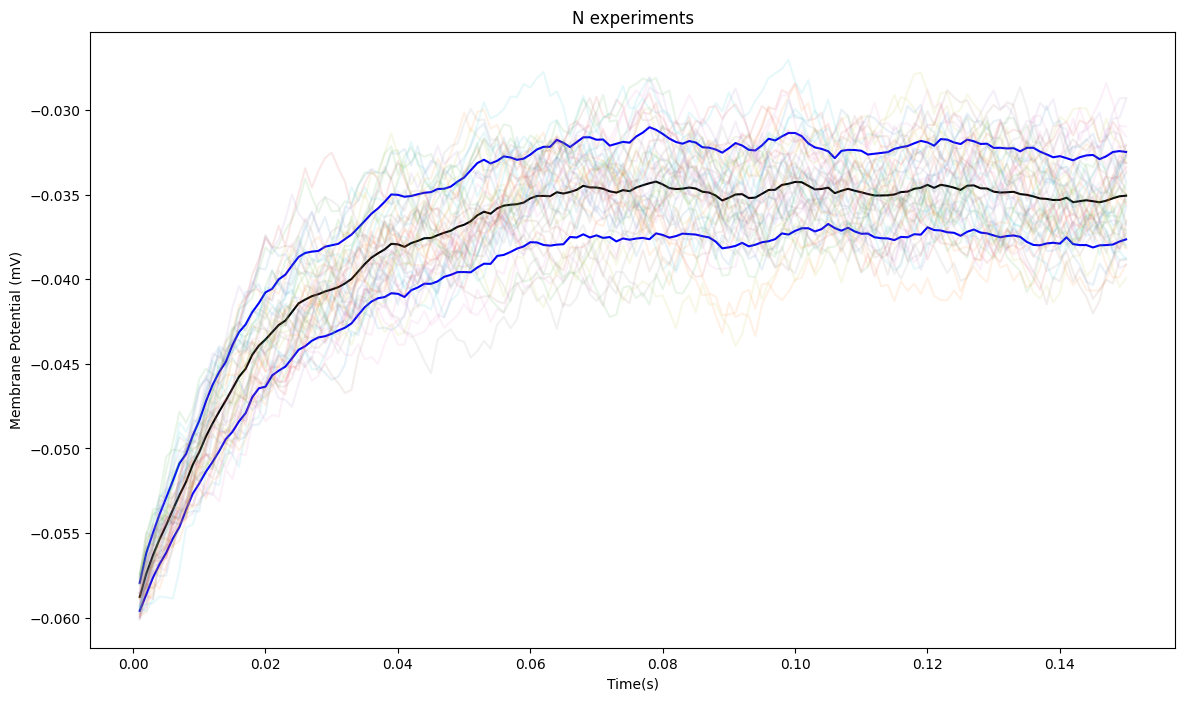

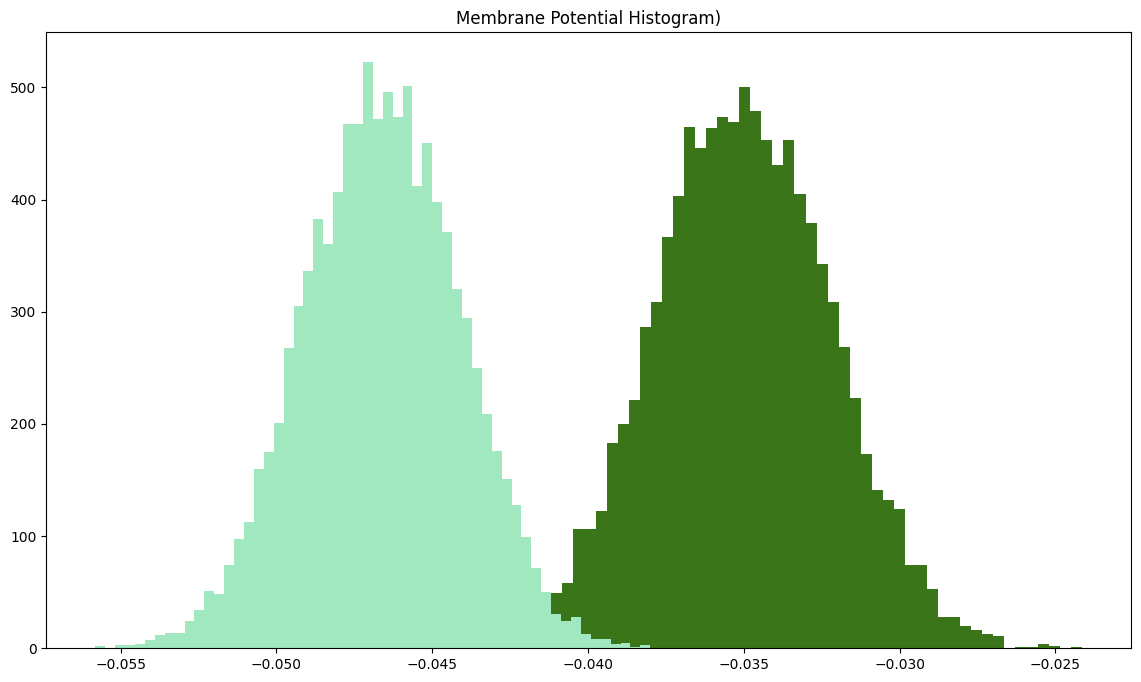

In [129]:
def n_membrane_potential_experiments_np(n: int) -> np.ndarray:
    realizations = []
    for i in range(n):
        synaptic_inputs, _ = synaptic_input_random(i_mean, 0.0, t_max, dt, rng)
        potentials, times = membrane_potential(el, 0.0, t_max, dt, synaptic_inputs)
        realizations.append([potentials, times])
    return np.array(realizations)

plt.figure(figsize=(14, 8))
curr_ax = plt.gca()
experiments = n_membrane_potential_experiments_np(50)
experiment_means = np.mean(experiments, axis=0)
experiment_stdv = np.std(experiments[:,0,:], axis=0) # Select only the potentials
plot_n_experiments(curr_ax, experiments, experiment_means, experiment_stdv)
plt.show()


plt.figure(figsize=(14, 8))
curr_ax = plt.gca()
# Get potentials at t_max / 10, and at t_max
experiments = n_membrane_potential_experiments_np(10000)
index_t_max_by_10 = int((t_max) / (10 * dt)) - 1
index_t_max = int(t_max / dt) - 1
potentials_at_t_max = experiments[:, 0, index_t_max]
potentials_at_t_max_by_10 = experiments[:, 0, index_t_max_by_10]

# Plot PDF (histogram) of potentials at these times
plot_histograms(curr_ax, [potentials_at_t_max, potentials_at_t_max_by_10])

plt.show()